In [1]:
import tensorflow as tf
import imageio
import natsort
import glob
import PIL
import IPython
import numpy as np
import matplotlib.pyplot as plt
from model import CVAE, Classifier
from tensorflow_probability import distributions as tfd
from dataset import preprocess_images
from tensorflow.linalg import matvec
from tensorflow_addons.image import rotate
import os
import random
import pandas as pd
from load_data import load_celeba
from inception_score import Inception_score
from test import normalize

In [84]:
def compute_inception_score(model, d, test_images):
    inception_model = Inception_score()
    r_x = rotate(test_images, d)
    mean, logvar = model.encode(test_images)
    r_m = np.identity(model.latent_dim)
    z = reparameterize(mean, logvar)
    c, s = np.cos(d), np.sin(d)
    r_m[0, [0, 1]], r_m[1, [0, 1]] = [c, s], [-s, c]
    rota_z = matvec(tf.cast(r_m, dtype=tf.float32), z)
    phi_x = model.sample(rota_z) 
    return phi_x, inception_model.compute_score(r_x, phi_x)

def compute_mnist_score(model, classifier, test_images, z=0, d=0, r_m=0, initial=False):
    if (initial==True):
        mean, logvar = model.encode(test_images)
        r_m = np.identity(model.latent_dim)
        z = reparameterize(mean, logvar)
        d = np.radians(random.randint(0, 90))
    c, s = np.cos(d), np.sin(d)
    r_m[0, [0, 1]], r_m[1, [0, 1]] = [c, s], [-s, c]
    rota_z = matvec(tf.cast(r_m, dtype=tf.float32), z)
    phi_x = model.sample(rota_z)
    scores = classifier.mnist_score(phi_x)
    return phi_x, np.mean(scores)

def generate_images(data, save=False, file_dir='.'):
    fig = plt.figure(figsize=(3, 3))
    for i in range(data.shape[0]):
        plt.subplot(3, 3, i + 1)
        plt.imshow(data[i, :, :, 0], cmap='gray')
        plt.axis('off')
    if(save):
        plt.savefig('image/mnist/'+file_dir, bbox_inches='tight')
    plt.show()

def reparameterize(mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar*.5) + mean

In [161]:
model = CVAE(latent_dim=8, beta=3)
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore("./checkpoints/3_3/sample_test5/ckpt-21")

In [188]:
classifier = Classifier(shape=(28, 28, 1))
cls = tf.train.Checkpoint(classifier = classifier)
cls.restore("./checkpoints/classifier/ckpt-1")

In [200]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
test_images = preprocess_images(test_images)
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(10000).batch(32))
num_examples_to_generate = 16
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]

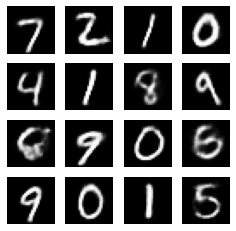

In [207]:
mean, logvar = model.encode(test_images)
z = model.reparameterize(mean, logvar)
r_m = np.identity(model.latent_dim)
predictions = model.sample(z)

In [244]:
theta = np.radians(0)
phi_x, score = compute_mnist_score(model, classifier, test_images, z, theta, r_m)
score = np.around(score, decimals=1)
print("mnist score is {}".format(score))

mnist score is 7.599999904632568


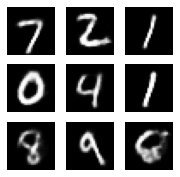

In [245]:
generate_images(phi_x[:9], save=True, file_dir='best')

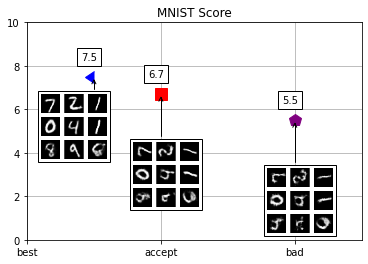

In [288]:
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, ax = plt.subplots()
quality = ['best', 'accept', 'bad']
color_list = ['blue', 'red', 'purple']
marker_list = [8, 's','p']
axis = [(0.2, 7.5), (0.4,6.7), (0.8, 5.5)]
ax.set_xlim(0, 1)
ax.set_ylim(0, 10)
image = []
for i in range(1):
    p, = ax.plot(axis[i][0], axis[i][1],color=color_list[i],
                   label=quality[i], marker=marker_list[i], markersize=12)
    image.append(p)
    arr_lena = mpimg.imread('./image/mnist/{}.png'.format(quality[i]))
    image.append(arr_lena)
    t = TextArea(axis[i][1], minimumdescent=False)
    t_box = AnnotationBbox(t, axis[i],
                    xybox=(-5, 20),
                    xycoords='data',
                    boxcoords="offset points")
    ax.add_artist(t_box)
    imagebox = OffsetImage(arr_lena, zoom=0.4)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, axis[i],
                    xybox=(-20., -50.),
                    xycoords='data',
                    boxcoords="offset points",
                    pad=0,
                    arrowprops=dict(
                        arrowstyle="->",
                        connectionstyle="angle,angleA=0,angleB=90,rad=3")
                    )
    
    ax.add_artist(ab)
for i in range(1,3):
    p, = ax.plot(axis[i][0], axis[i][1],color=color_list[i],
                   label=quality[i], marker=marker_list[i], markersize=12)
    image.append(p)
    t = TextArea(axis[i][1], minimumdescent=False)
    t_box = AnnotationBbox(t, axis[i],
                    xybox=(-5, 20),
                    xycoords='data',
                    boxcoords="offset points")
    ax.add_artist(t_box)
    imagebox = OffsetImage(arr_lena, zoom=0.4)
    arr_lena = mpimg.imread('./image/mnist/{}.png'.format(quality[i]))
    image.append(arr_lena)
    imagebox = OffsetImage(arr_lena, zoom=0.4)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, axis[i],
                    xybox=(5, -80.),
                    xycoords='data',
                    boxcoords="offset points",
                    pad=0,
                    arrowprops=dict(
                        arrowstyle="->",
                        connectionstyle="angle,angleA=0,angleB=90,rad=3")
                    )

    ax.add_artist(ab)
plt.xticks([0, 0.4, 0.8], ['best', 'accept', 'bad'])
plt.title('MNIST Score')
plt.grid()
plt.draw()
plt.savefig('mnist_score.png',bbox_inches='tight', dpi=400)
plt.show()

# celeba

In [107]:
dataset = load_celeba("../CelebA")
model = CVAE(latent_dim=64, beta=1, shape=[32,32,3])
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore("./checkpoints/4_6/sample_size2/ckpt-31")

In [4]:
test_set_size = 2000

test_dataset = dataset[200000:200000+test_set_size]
test_images = normalize(test_dataset)
test_dataset = (tf.data.Dataset.from_tensor_slices(test_dataset)
                .shuffle(10000).batch(32))

In [5]:
def generate_celeb(data, save=False, file_dir='.'):
    fig = plt.figure(figsize=(3,3))
    display_list = data
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(data[i])
        plt.axis('off')
    if(save):
        plt.savefig('image/celeb/'+file_dir, bbox_inches='tight')
    plt.show()

In [6]:
num_examples_to_generate = 9
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]

In [ ]:
theta = np.radians(90)
phi_x, score = compute_inception_score(model, theta, test_images)
score = np.around(score, decimals=2)
print("fid is {}".format(score))

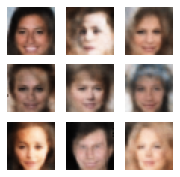

In [113]:
generate_celeb(phi_x[:9], save=True, file_dir='bad')
#generate_celeb(phi_x[:9], file_dir='best')

In [71]:
model_list = {}
for j in range(2,12,2):
    model = CVAE(latent_dim=64, beta=4, shape=[32,32,3])
    checkpoint_path = "./checkpoints/4_6/sample_test{}/".format(j)
    optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    ckpt = tf.train.Checkpoint(model=model,
                               optimizer=optimizer)
    ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
    ckpt.restore(ckpt_manager.latest_checkpoint)
    score_list = []
    for i in range(0, 100, 10):
        theta = np.radians(i)
        phi_x, score = compute_inception_score(model, theta, test_images,gamma=0.1)
        score = np.around(score, decimals=2)
        score_list.append(score)
    model_list[j] = score_list

NameError: name 'row' is not defined

In [46]:
model_list

{2: [1.04, 1.13, 1.2, 1.16, 1.19, 1.22, 1.25, 1.27, 1.15, 1.2],
 4: [1.03, 1.12, 1.18, 1.11, 1.14, 1.19, 1.23, 1.23, 1.15, 1.19],
 6: [1.05, 1.14, 1.23, 1.16, 1.18, 1.23, 1.29, 1.28, 1.16, 1.22],
 8: [1.04, 1.12, 1.2, 1.13, 1.15, 1.23, 1.24, 1.25, 1.12, 1.16],
 10: [1.07, 1.15, 1.26, 1.22, 1.24, 1.29, 1.28, 1.27, 1.14, 1.15]}

In [43]:
model_list[2]

1.2

In [38]:
np.mean(score_list)

1.691

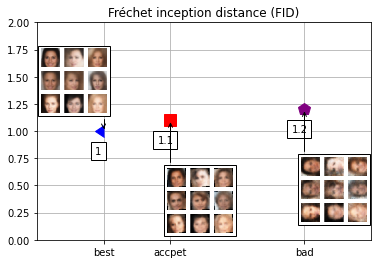

In [106]:
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, ax = plt.subplots()
quality = ['best', 'accept', 'bad']
color_list = ['blue', 'red', 'purple']
marker_list = [8, 's','p']
axis = [(0.2, 1), (0.4,1.1), (0.8, 1.2)]
ax.set_xlim(0, 1)
ax.set_ylim(0, 2)
image = []
for i in range(1):
    p, = ax.plot(axis[i][0], axis[i][1],color=color_list[i],
                   label=quality[i], marker=marker_list[i], markersize=12)
    image.append(p)
    t = TextArea(axis[i][1], minimumdescent=False)
    t_box = AnnotationBbox(t, axis[i],
                    xybox=(-5, -20),
                    xycoords='data',
                    boxcoords="offset points")
    ax.add_artist(t_box)
    arr_lena = mpimg.imread('./image/celeb/{}.png'.format(quality[i]))
    image.append(arr_lena)
    imagebox = OffsetImage(arr_lena, zoom=0.4)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, axis[i],
                    xybox=(-30., 50.),
                    xycoords='data',
                    boxcoords="offset points",
                    pad=0,
                    arrowprops=dict(
                        arrowstyle="->",
                        connectionstyle="angle,angleA=0,angleB=90,rad=3")
                    )

    ax.add_artist(ab)
for i in range(1,3):
    p, = ax.plot(axis[i][0], axis[i][1],color=color_list[i],
                   label=quality[i], marker=marker_list[i], markersize=12)
    image.append(p)
    t = TextArea(axis[i][1], minimumdescent=False)
    t_box = AnnotationBbox(t, axis[i],
                    xybox=(-5, -20),
                    xycoords='data',
                    boxcoords="offset points")
    ax.add_artist(t_box)
    arr_lena = mpimg.imread('./image/celeb/{}.png'.format(quality[i]))
    image.append(arr_lena)
    imagebox = OffsetImage(arr_lena, zoom=0.4)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, axis[i],
                    xybox=(30., -80.),
                    xycoords='data',
                    boxcoords="offset points",
                    pad=0,
                    arrowprops=dict(
                        arrowstyle="->",
                        connectionstyle="angle,angleA=0,angleB=90,rad=3")
                    )

    ax.add_artist(ab)
plt.xticks([0.2, 0.4, 0.8], ['best', 'accpet', "bad"])
plt.title('Fréchet inception distance (FID)')
plt.grid()
plt.draw()
plt.savefig('celeb_fid_distance.png',bbox_inches='tight', dpi=400)
plt.show()

In [115]:
axis[i][0]

0.2